# Extract Lightning Photos from Video

Capturing Lightning photo using mobile is a challenging as lightning frequency is random and its strike at a high speed.  

Here is my solution and the photo below shows the success.  

Steps to take on mobile:
1. Please use a stable tripod for your mobile.  The mobile should not be shaking even there is storm winds. This software is detecting changes between frames (i.e. changes detection).  Hence, a shaking video capture will caused too many photos falsely captured.
2. If possible, please the mobile profession video mode.  Do set the ISO to a low range (about 50-120) so that the lightning flash would not white the whole frame.

Place the video (mp4) in your Google Drive as stated in below.  Lightning captured image file(s) (PNG) will be in the respective video file name folders.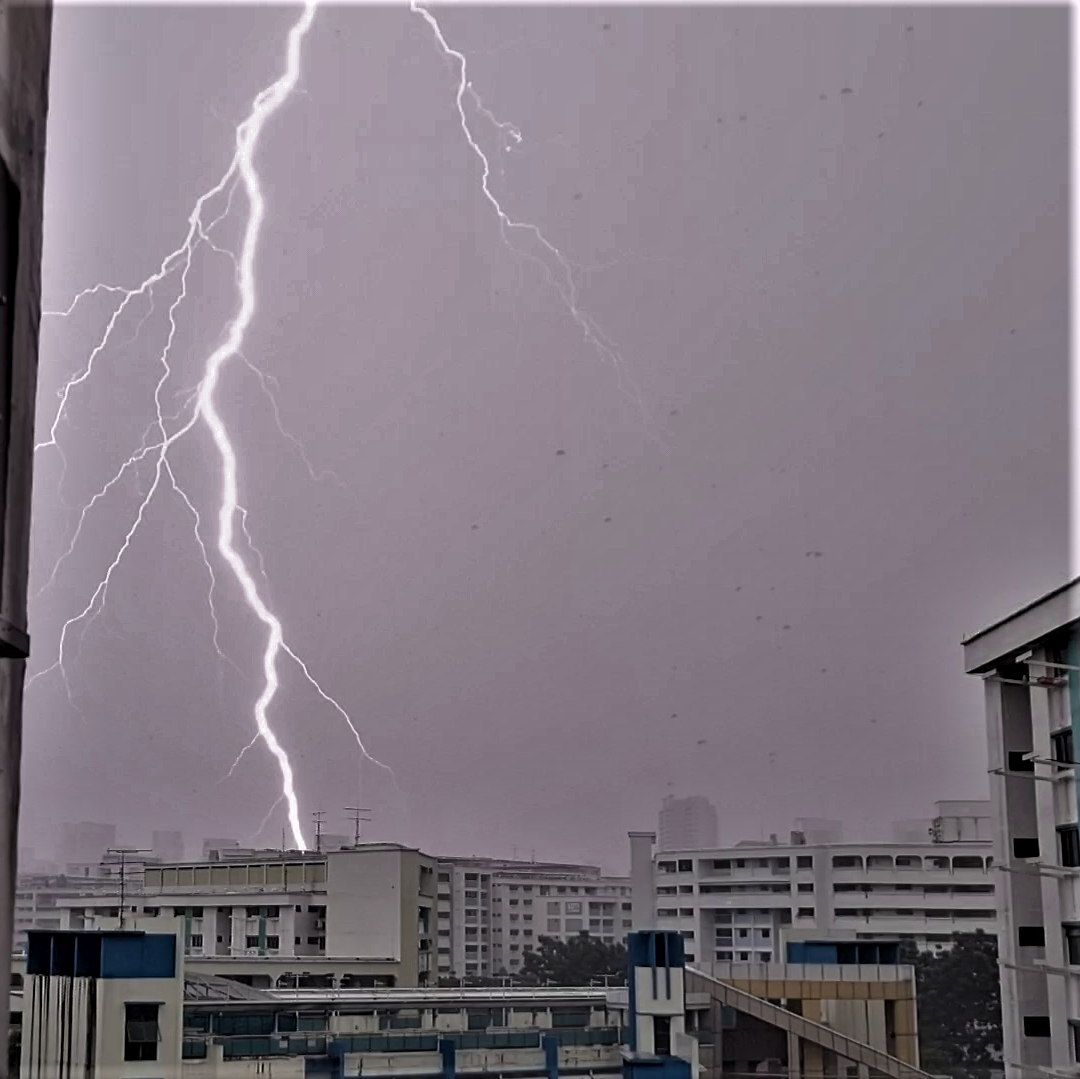

## Lightning 'crawling' the sky or hit the ground
If your mobile video camera is fast enough, you may piece together each lightning photos and form how the lightning crawl the sky or how it hits the ground.

## References

1. Changes in video frames: https://docs.opencv.org/3.4/d1/dc5/tutorial_background_subtraction.html
2. Bright spot detection: https://www.pyimagesearch.com/2016/10/31/detecting-multiple-bright-spots-in-an-image-with-python-and-opencv/
3. Progress bar in Colab:
*   https://towardsdatascience.com/ever-wanted-progress-bars-in-jupyter-bdb3988d9cfc
*   https://towardsdatascience.com/progress-bars-in-python-4b44e8a4c482



# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/Photo')

Mounted at /content/Photo


Libraries imports

In [ ]:
from __future__ import print_function
import cv2

from imutils import contours
from skimage import measure
import numpy as np
import imutils

import os

For progress bar

In [ ]:
from tqdm.notebook import tqdm, trange # https://towardsdatascience.com/ever-wanted-progress-bars-in-jupyter-bdb3988d9cfc
                                       # https://towardsdatascience.com/progress-bars-in-python-4b44e8a4c482

Background subtraction method (KNN or MOG2): choose one by masking

In [ ]:
# unmask one
backSub = cv2.createBackgroundSubtractorMOG2()
#backSub = cv2.createBackgroundSubtractorKNN()

Hyper Paramenters for Background Subtraction

In [ ]:
threshold = 50000 # The threshold to qualify for lightning. MOG2: 5000, 10000, 20000, 50000 KNN: 50000
spause = 1000 # The number of milliseconds to wait at the beginning of the video before detecting.

# Lightning Detection Main Loop

Please place your all your ligthning videos (mp4) in your Google Drive.  For example your video folder is "14June2022" in "My Drive" then 'google_drive_folder' should be initalized as follows:

```
google_drive_folder = '/content/Photo/My Drive/14June2022/'
```

The detected lightning photos will be placed at the above folder sub-folder(s).  Each sub-folder is named after the video file.

**Note:** The time taken to detection and extraction is proportional to the lenght of the video: i.e. longer the video, longer will be the process.

In [ ]:
# iterate over files in
# that directory
google_drive_folder = '/content/Photo/My Drive/14June2022/'

i = 0

# Get number of mp4 files
list = os.listdir(google_drive_folder) # dir is your directory path
number_files = len(list)

for mp4_name in os.scandir(google_drive_folder):
  if mp4_name.is_file():
    # This is formatted as code
    mp4_input = google_drive_folder + mp4_name.name
    photos_save_folder = google_drive_folder + mp4_name.name.rsplit( ".", 1 )[ 0 ] + "/"

    # Make photo output folder
    os.mkdir(photos_save_folder) # https://stackoverflow.com/questions/60706752/how-to-make-directory-on-the-google-colab

    # Progress bar updating variables
    prev_number = 0
    number = 0

    # Start processing current mp4
    print('Processing file:', i+1,'/',number_files, ' Filename:', mp4_name.name)

    #capture = cv2.VideoCapture(cv2.samples.findFileOrKeep(args.input))
    capture = cv2.VideoCapture(mp4_input)

    nTotalFrame = capture.get(cv2.CAP_PROP_FRAME_COUNT) # total frames
    p_bar = tqdm(range(100)) # progress bar

    if not capture.isOpened:
        print('Unable to open: mp4')
        continue

    while True:
        ret, frame = capture.read()
        if frame is None:
            break

        fgMask = backSub.apply(frame)

        #cv2.rectangle(frame, (10, 2), (100,20), (255,255,255), -1)
        fps = capture.get(cv2.CAP_PROP_FPS)
        nFrame = capture.get(cv2.CAP_PROP_POS_FRAMES)
        m_sec = capture.get(cv2.CAP_PROP_POS_MSEC)
        #cv2.putText(frame, str(nFrame), (15, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))

        number = (nFrame / nTotalFrame) * 100
        update_value = number - prev_number
        #p_bar.set_description(f'Working on "{number}"') # update progress bar
        p_bar.update(update_value)
        prev_number = number

        blurred = cv2.GaussianBlur(fgMask, (11, 11), 0)

        # threshold the image to reveal light regions in the
        # blurred image
        thresh = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)[1]

        # perform a series of erosions and dilations to remove
        # any small blobs of noise from the thresholded image
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=4)

        # perform a connected component analysis on the thresholded
        # image, then initialize a mask to store only the "large"
        # components
        #labels = measure.label(thresh, neighbors=8, background=0)
        labels = measure.label(thresh, connectivity=2, background=0)
        mask = np.zeros(thresh.shape, dtype="uint8")
        # loop over the unique components
        for label in np.unique(labels):
            # if this is the background label, ignore it
            if label == 0:
                    continue
            # otherwise, construct the label mask and count the
            # number of pixels
            labelMask = np.zeros(thresh.shape, dtype="uint8")
            labelMask[labels == label] = 255
            numPixels = cv2.countNonZero(labelMask)
            # if the number of pixels in the component is sufficiently
            # large, then add it to our mask of "large blobs"
            if numPixels > threshold and m_sec > spause:
                mask = cv2.add(mask, labelMask)
                #print(m_sec/1000, " sec")
                file = photos_save_folder + str("{:.0f}".format(m_sec)) + '_' + str(numPixels) +'.png'
                cv2.imwrite(file,frame)
                #print(file, ' saved')


        #cv2.imshow('Frame', frame)
        #cv2.imshow('FG Mask', fgMask)

    print('Completed, last file: ' + file)
    i+=1

Processing file: 1 / 1  Filename: 20220614_213006.mp4


  0%|          | 0/100 [00:00<?, ?it/s]

Completed, last file: /content/Photo/My Drive/14June2022/20220614_213006/22489_70286.png
